# QuantAlpha Engine — 因子回测框架完整演示

**框架结构：**
```
quant_alpha_engine/
├── data/mock_generator.py   # 模拟数据生成器（GBM + 行业共同因子）
├── ops/alpha_ops.py         # 全部算子库（时序 + 截面 + 特殊）
├── backtest/
│   ├── performance.py       # 绩效指标计算
│   └── vector_engine.py     # 矩阵式净值回测引擎
└── visualization/report.py  # Matplotlib 6子图报告
```

**工作流：**
```
数据生成 → 算子组合构造因子 → VectorEngine 一行运行回测 → 自动打印指标 + 绘图
```

## 0. 环境准备

In [1]:
# 确认当前工作目录（需要在 quant_alpha_engine 的父目录下运行）
import os
print('当前路径:', os.getcwd())

# 如果路径不对，取消注释并修改以下行：
# os.chdir(r'D:\Stock\Frame')  # ← 修改为实际路径

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Jupyter 内联显示图表
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

当前路径: d:\Stock\Frame


## 1. 导入框架

In [2]:
from quant_alpha_engine import MockDataGenerator
from quant_alpha_engine.ops import AlphaOps as op
from quant_alpha_engine.backtest import VectorEngine
from quant_alpha_engine.backtest.performance import Performance

print('✅ QuantAlpha Engine 导入成功')

✅ QuantAlpha Engine 导入成功


## 2. 生成模拟市场数据

**MockDataGenerator** 基于 GBM（几何布朗运动）叠加行业共同因子，生成含真实市场特征的模拟数据：
- 行业内股票具有正相关性（行业共同因子）
- 自动生成停牌、涨跌停状态矩阵
- 成交量与价格波动正相关（量价关系）

In [3]:
# 生成数据
gen = MockDataGenerator(
    n_stocks    = 100,          # 股票数量
    n_days      = 504,          # 交易日数（约2年）
    n_industries = 10,          # 行业数量
    seed        = 42,           # 随机种子（固定复现）
    mu          = 0.08,         # 年化漂移率（基础）
    sigma       = 0.30,         # 年化波动率（基础）
)
data = gen.generate()

# 提取各数据字段
close    = data.close
volume   = data.volume
high     = data.high
low      = data.low
industry = data.industry     # Series: stock -> industry_name
is_susp  = data.is_suspended  # DataFrame: bool
is_limit = data.is_limit      # DataFrame: bool

print(f'价格数据维度:   {close.shape}  (交易日 × 股票)')
print(f'数据时间范围:   {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'停牌天数比例:   {is_susp.values.mean()*100:.2f}%')
print(f'涨跌停天数比例: {is_limit.values.mean()*100:.2f}%')
print(f'\n行业分布：')
print(industry.value_counts())

价格数据维度:   (504, 100)  (交易日 × 股票)
数据时间范围:   2022-01-03 ~ 2023-12-07
停牌天数比例:   0.17%
涨跌停天数比例: 0.00%

行业分布：
industry
行业万    15
行业丄    15
行业一    10
行业丆    10
行业七     9
行业丈     9
行业丁     9
行业丅     9
行业三     8
行业丂     6
Name: count, dtype: int64


## 3. AlphaOps 算子库使用说明

所有算子均支持 `DataFrame` 向量化运算，可自由嵌套组合。

| 类别 | 算子 | 说明 |
|------|------|------|
| 时序 | `Ts_Sum / Ts_Mean / Ts_Max / Ts_Min` | 滑动窗口统计 |
| 时序 | `Ts_Delta(df, period)` | 当前值 - N天前值 |
| 时序 | `Ts_Delay(df, period)` | 数据滞后 N 天 |
| 时序 | `Ts_Std(df, window)` | 滑动窗口标准差 |
| 时序 | `Ts_Rank(df, window)` | 窗口内百分比排名 |
| 时序 | `Ts_Corr(df1, df2, window)` | 滚动相关系数 |
| 截面 | `Rank(df)` | 全市场截面百分比排名 |
| 截面 | `ZScore(df)` | 截面标准化 |
| 截面 | `Scale(df, a=1)` | 截面绝对值缩放至 a |
| 特殊 | `Decay_Linear(df, d)` | 线性加权移动平均 |
| 特殊 | `Neutralize(df, industry)` | 行业中性化（OLS残差法）|

In [4]:
# ─── 快速验证各算子 ───

# 时序算子示例
ma5   = op.Ts_Mean(close, 5)
delta = op.Ts_Delta(close, 20)
std20 = op.Ts_Std(close, 20)
corr  = op.Ts_Corr(volume, close, 10)

# 截面算子示例
rank_factor  = op.Rank(delta)
zscore_factor = op.ZScore(delta)

# 特殊算子示例
decay_factor = op.Decay_Linear(rank_factor, d=5)
neut_factor  = op.Neutralize(rank_factor, industry)

print('✅ 所有算子运行正常')
print(f'   Rank 因子范围: [{rank_factor.stack().min():.4f}, {rank_factor.stack().max():.4f}]')
print(f'   ZScore 因子均值: {zscore_factor.stack().mean():.6f}')
print(f'   Decay_Linear 因子维度: {decay_factor.shape}')
print(f'   Neutralize 后均值: {neut_factor.stack().mean():.6f}  (应接近0)')

✅ 所有算子运行正常
   Rank 因子范围: [0.0100, 1.0000]
   ZScore 因子均值: 0.000000
   Decay_Linear 因子维度: (504, 100)
   Neutralize 后均值: 0.000000  (应接近0)


In [5]:
ma5

stock,SH600000,SH600001,SH600002,SH600003,SH600004,SH600005,SH600006,SH600007,SH600008,SH600009,...,SH600090,SH600091,SH600092,SH600093,SH600094,SH600095,SH600096,SH600097,SH600098,SH600099
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,12.224931,12.277492,46.011076,64.369965,30.710388,90.011061,28.989848,35.429221,34.969621,24.666659,...,49.830827,87.512384,72.313205,16.698687,98.300275,72.041090,24.964571,53.218830,32.322549,63.891807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,11.429234,13.247910,16.878607,71.126225,48.783824,153.416510,32.115628,33.649289,30.801212,28.259064,...,25.914145,68.274796,75.393207,11.447909,54.700079,53.606094,16.885052,23.174716,25.047793,133.701794
2023-12-04,11.543989,13.334584,16.885528,70.824840,49.034458,152.283899,31.853363,33.627888,30.849433,28.701007,...,26.293131,68.921278,75.340469,11.622845,54.566043,54.029815,17.016766,22.636272,24.743068,132.301361
2023-12-05,11.619144,13.434022,16.995348,70.284146,49.441483,148.486703,31.606017,33.517990,30.636636,29.024838,...,26.864167,68.720244,75.468587,11.833414,54.793182,54.686086,17.069713,22.194136,24.547042,131.289618


## 4. 构建 Alpha 因子

以下展示 3 个不同逻辑的因子，支持任意嵌套组合：

In [6]:
# ─── 因子 1：反转动量因子 ───
# 逻辑：近期跌幅越大的股票，均值回归预期更强
# 公式：Rank(-Ts_Delta(close, 5))
factor_reversal = op.Rank(-op.Ts_Delta(close, 5))
print('✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))')

# ─── 因子 2：量价背离因子（行业中性化）───
# 逻辑：缩量上涨（量价负相关）是强势信号
# 公式：Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
factor_volprice = op.Neutralize(
    op.Rank(-op.Ts_Corr(volume, close, window=10)),
    industry
)
print('✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)')

# ─── 因子 3：综合技术因子 ───
# 逻辑：线性衰减加权的动量信号，ZScore 标准化
# 公式：ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))
factor_tech = op.ZScore(
    op.Decay_Linear(
        op.Rank(op.Ts_Delta(close, 10)),
        d=5
    )
)
print('✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))')

✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))
✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))


## 5. 单因子回测

只需传入因子矩阵和行情数据，即可获得完整回测结果：

In [7]:
# ─── 回测因子 1：反转动量因子 ───
print('=' * 55)
print('  回测：反转动量因子')
print('=' * 55)

engine1 = VectorEngine(
    factor         = factor_reversal,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 5,         # 每周调仓（5个交易日）
    top_n          = 30,        # 持仓 30 只股票
    weight_method  = 'equal',   # 等权持仓
    cost_rate      = 0.0015,    # 单边 0.15%（手续费+滑点）
)
result1 = engine1.run()
result1.print_summary()

  回测：反转动量因子
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔══════════════════════════════════════════════╗
║          QuantAlpha Engine — 回测绩效报告          ║
╠══════════════════════════════════════════════╣
║  年化收益率           │                     3.73%  ║
║  年化波动率           │                     8.05%  ║
║  Sharpe Ratio    │                   0.4952   ║
║  Calmar Ratio    │                   0.3414   ║
║  最大回撤            │                   -10.93%  ║
║  IC 均值           │                   0.0100   ║
║  IC 标准差          │                   0.1215   ║
║  ICIR            │                   1.3123   ║
║  IC 胜率           │                    54.22%  ║
║  IC t-stat       │                   1.8448   ║
║  日均换手率           │                    13.11%  ║
║  年化手续费           │                     4.96%  ║
║  Fitness         │                   0.2642   ║
╚════════════════════════

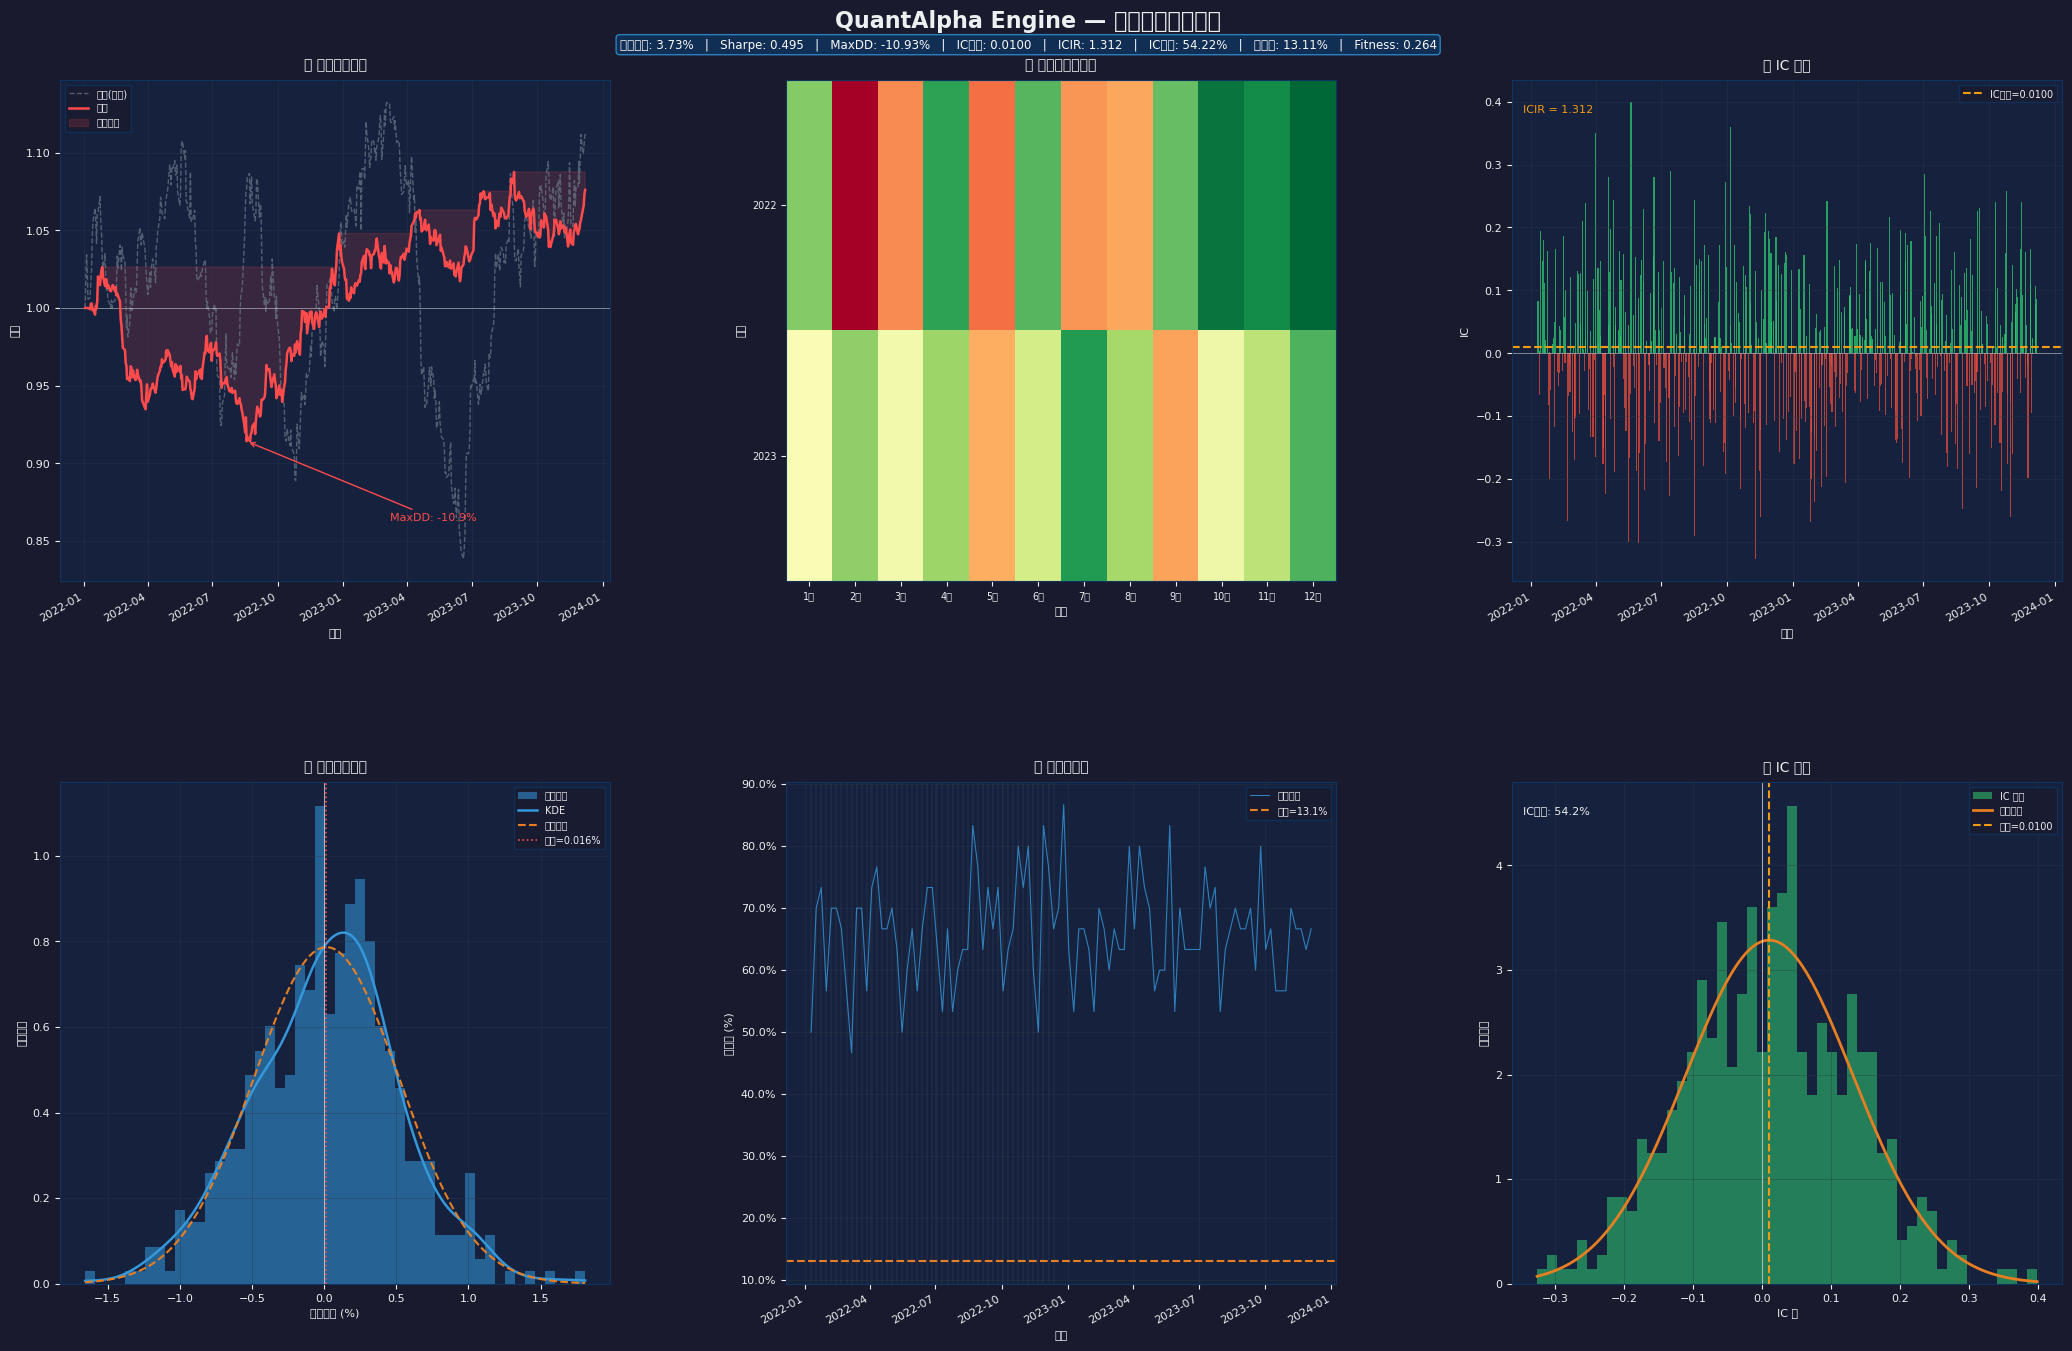

In [8]:
# 绘制因子1的完整回测报告
result1.plot()

  回测：量价背离因子（行业中性化）
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔══════════════════════════════════════════════╗
║          QuantAlpha Engine — 回测绩效报告          ║
╠══════════════════════════════════════════════╣
║  年化收益率           │                    -0.44%  ║
║  年化波动率           │                     7.43%  ║
║  Sharpe Ratio    │                  -0.0216   ║
║  Calmar Ratio    │                  -0.0432   ║
║  最大回撤            │                   -10.07%  ║
║  IC 均值           │                   0.0095   ║
║  IC 标准差          │                   0.0866   ║
║  ICIR            │                   1.7369   ║
║  IC 胜率           │                    54.86%  ║
║  IC t-stat       │                   2.4319   ║
║  日均换手率           │                    11.65%  ║
║  年化手续费           │                     4.40%  ║
║  Fitness         │                  -0.0042   ║
╚═════════════════

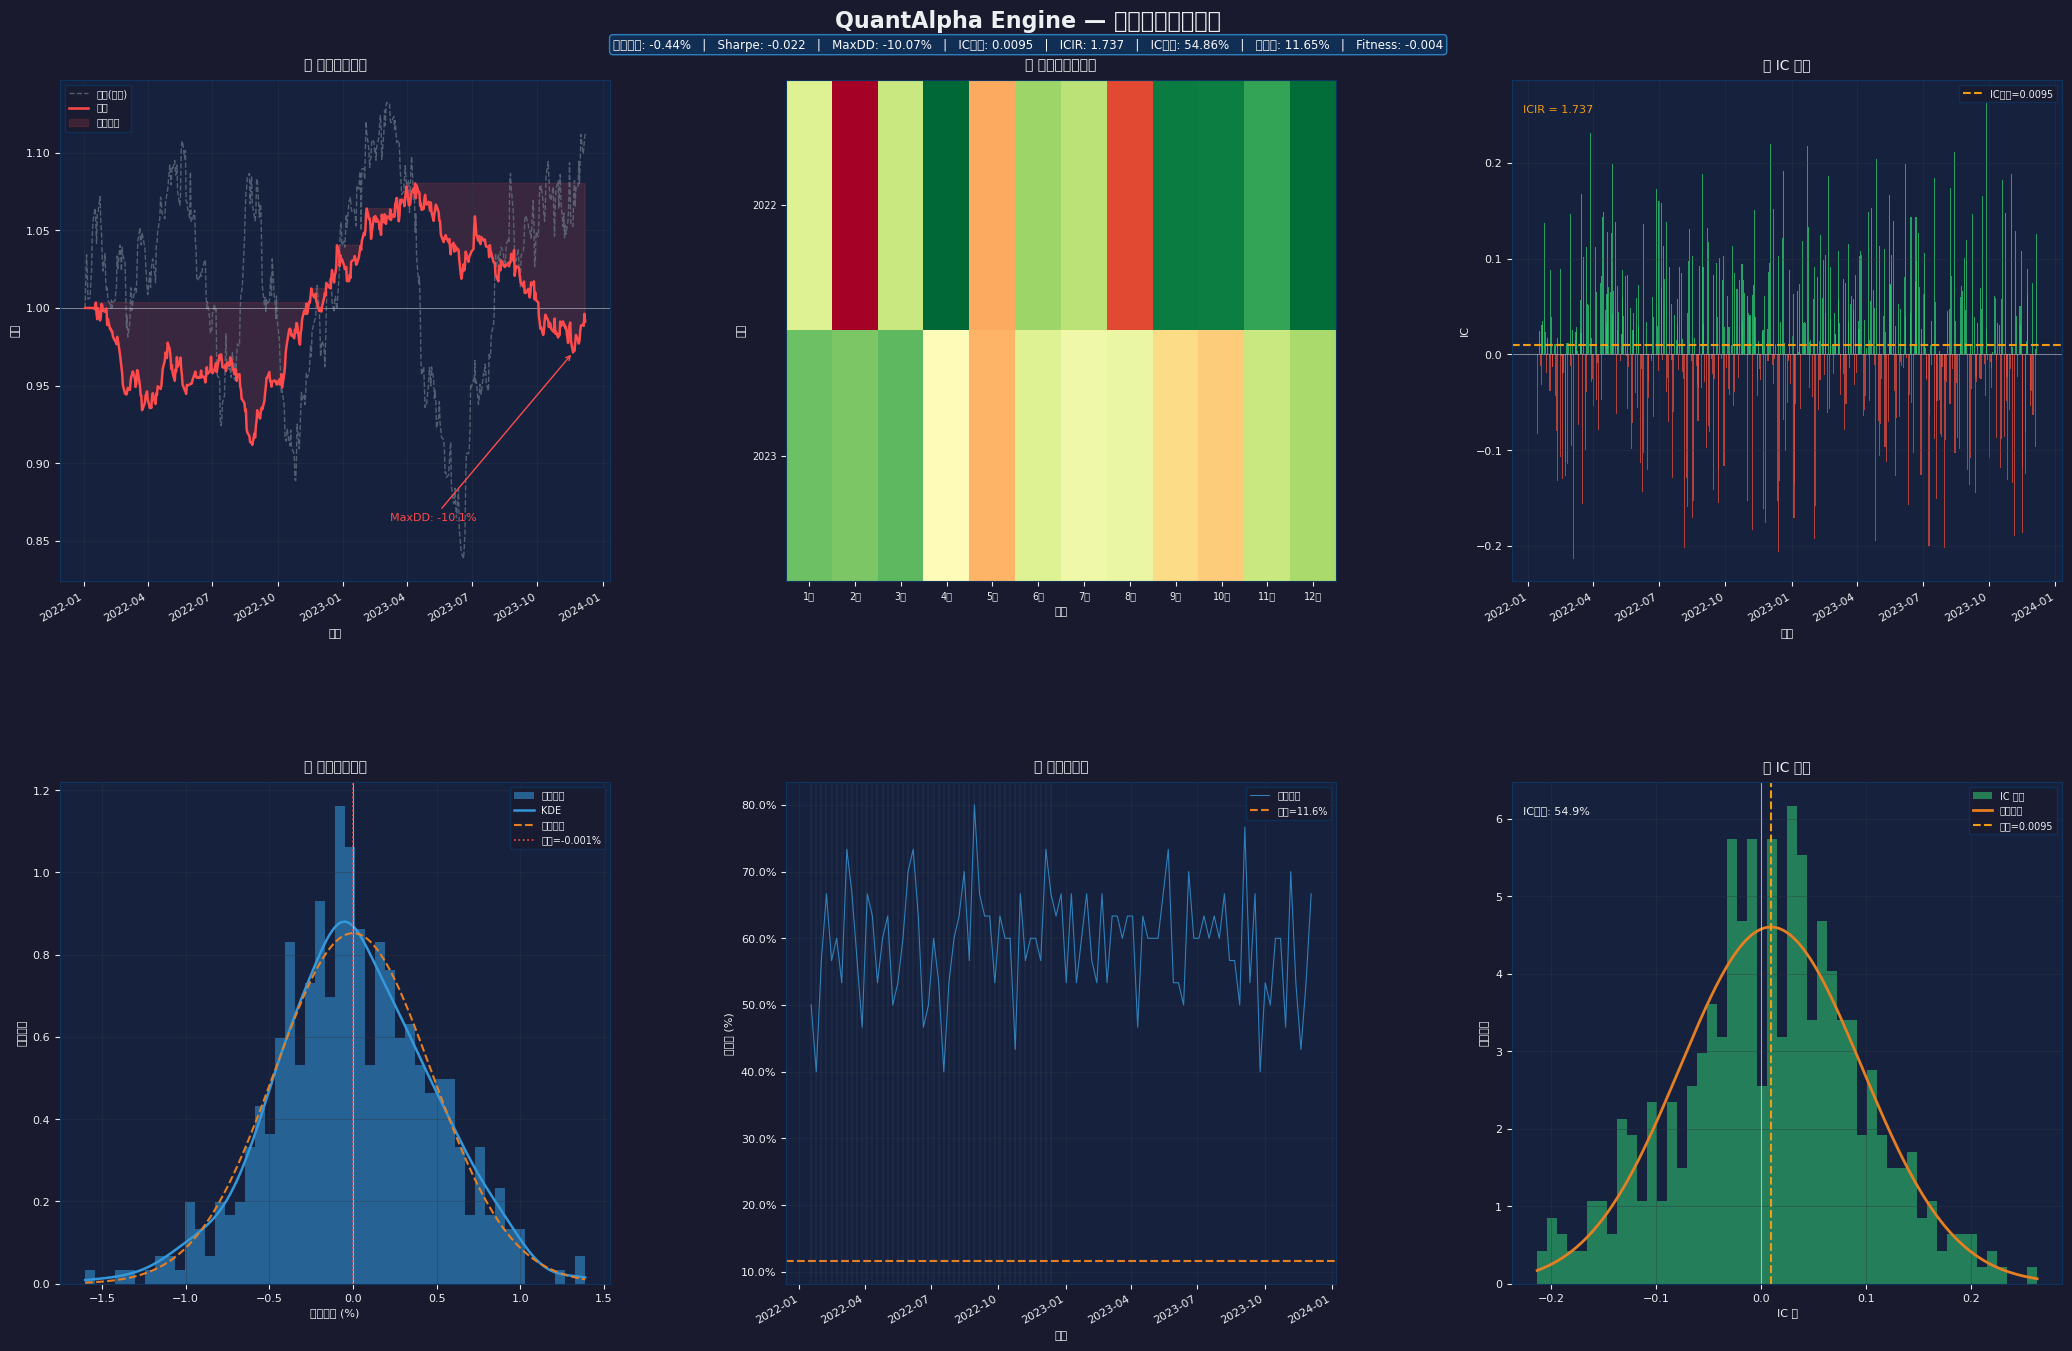

In [9]:
# ─── 回测因子 2：量价背离因子 ───
print('=' * 55)
print('  回测：量价背离因子（行业中性化）')
print('=' * 55)

engine2 = VectorEngine(
    factor         = factor_volprice,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 5,
    top_n          = 30,
    weight_method  = 'equal',
    cost_rate      = 0.0015,
)
result2 = engine2.run()
result2.print_summary()
result2.plot()

  回测：综合技术因子
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔══════════════════════════════════════════════╗
║          QuantAlpha Engine — 回测绩效报告          ║
╠══════════════════════════════════════════════╣
║  年化收益率           │                    -1.74%  ║
║  年化波动率           │                     7.58%  ║
║  Sharpe Ratio    │                  -0.1944   ║
║  Calmar Ratio    │                  -0.1368   ║
║  最大回撤            │                   -12.75%  ║
║  IC 均值           │                  -0.0024   ║
║  IC 标准差          │                   0.1231   ║
║  ICIR            │                  -0.3143   ║
║  IC 胜率           │                    46.75%  ║
║  IC t-stat       │                  -0.4391   ║
║  日均换手率           │                     8.31%  ║
║  年化手续费           │                     3.14%  ║
║  Fitness         │                  -0.0891   ║
╚════════════════════════

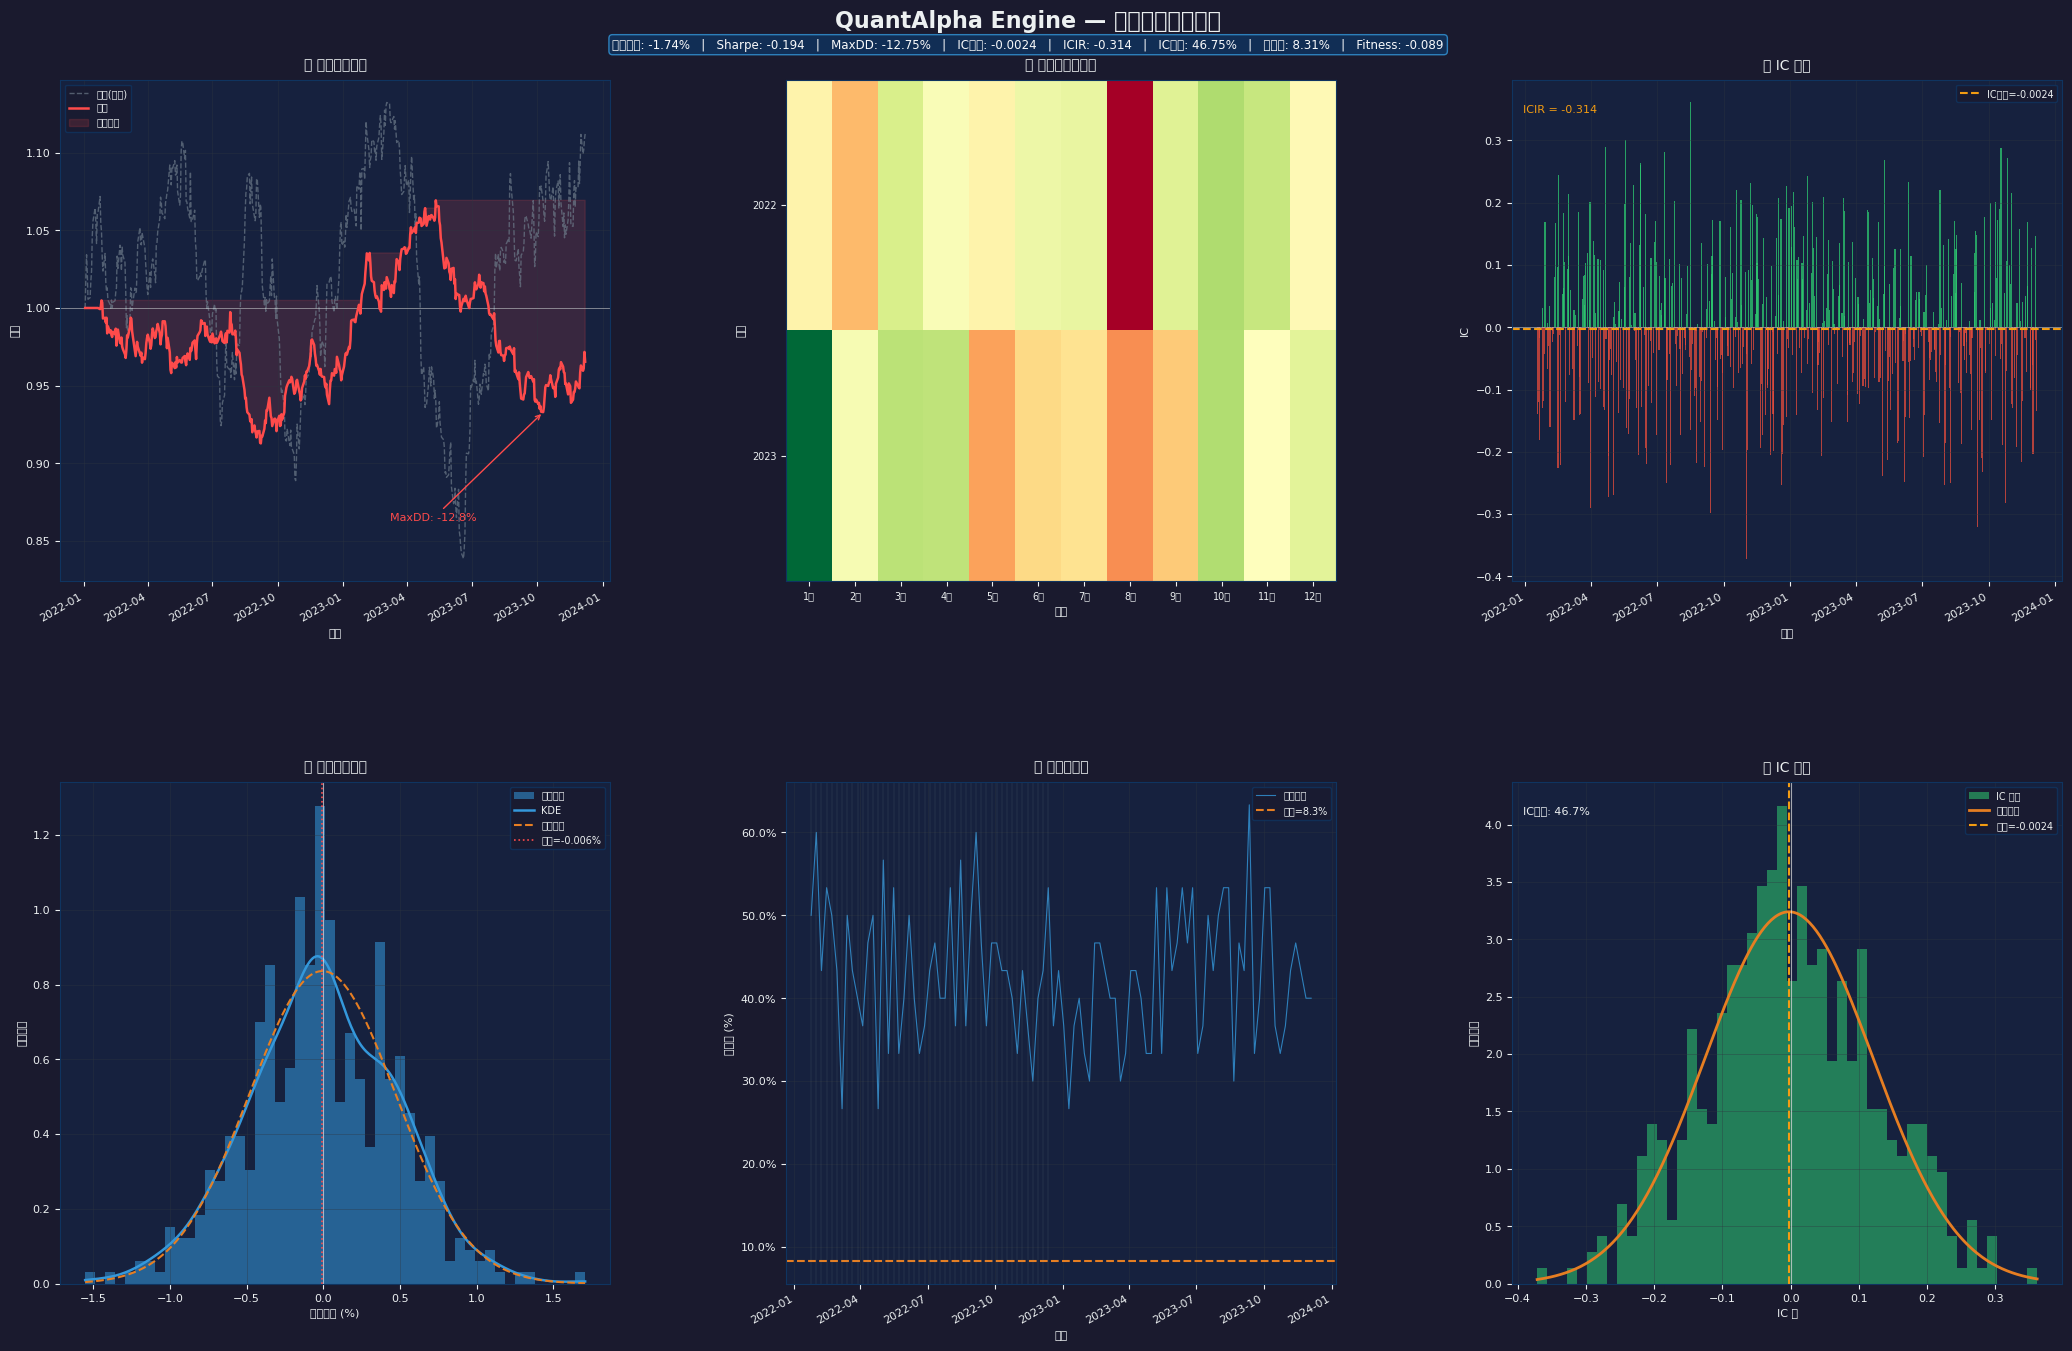

In [10]:
# ─── 回测因子 3：综合技术因子 ───
print('=' * 55)
print('  回测：综合技术因子')
print('=' * 55)

engine3 = VectorEngine(
    factor         = factor_tech,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 5,
    top_n          = 30,
    weight_method  = 'equal',
    cost_rate      = 0.0015,
)
result3 = engine3.run()
result3.print_summary()
result3.plot()

## 6. 三因子绩效对比

In [11]:
# 汇总对比表
comparison = pd.DataFrame({
    '反转动量':  result1.metrics,
    '量价背离':  result2.metrics,
    '技术动量':  result3.metrics,
}).T

# 选择核心指标展示
key_cols = ['年化收益率', '年化波动率', 'Sharpe_Ratio', '最大回撤',
            'IC_Mean', 'ICIR', 'IC_胜率', '日均换手率', 'Fitness']
display_df = comparison[key_cols].copy()

# 格式化显示
pct_cols = ['年化收益率', '年化波动率', '最大回撤', 'IC_胜率', '日均换手率']
for col in pct_cols:
    display_df[col] = display_df[col].apply(lambda v: f'{v*100:.2f}%' if pd.notna(v) else 'N/A')
for col in ['Sharpe_Ratio', 'IC_Mean', 'ICIR', 'Fitness']:
    display_df[col] = display_df[col].apply(lambda v: f'{v:.4f}' if pd.notna(v) else 'N/A')

print('\n=== 三因子绩效对比 ===')
print(display_df.to_string())


=== 三因子绩效对比 ===
       年化收益率  年化波动率 Sharpe_Ratio     最大回撤  IC_Mean     ICIR   IC_胜率   日均换手率  Fitness
反转动量   3.73%  8.05%       0.4952  -10.93%   0.0100   1.3123  54.22%  13.11%   0.2642
量价背离  -0.44%  7.43%      -0.0216  -10.07%   0.0095   1.7369  54.86%  11.65%  -0.0042
技术动量  -1.74%  7.58%      -0.1944  -12.75%  -0.0024  -0.3143  46.75%   8.31%  -0.0891


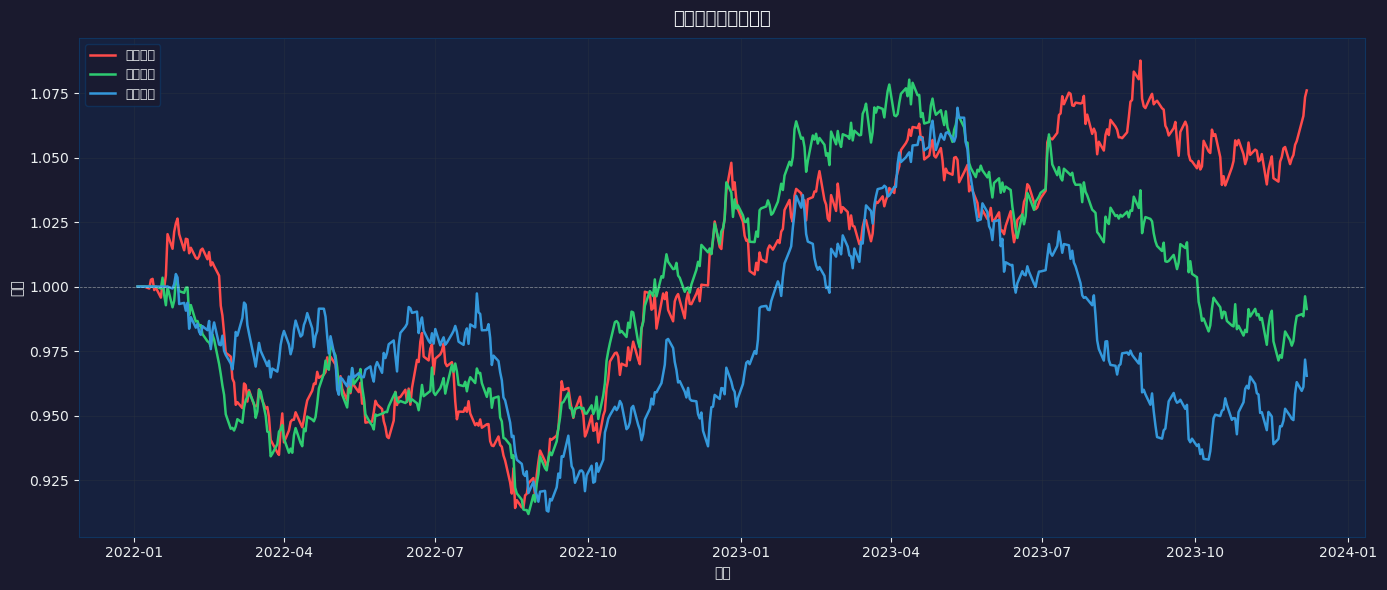

In [12]:
# 净值曲线对比图
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')
ax.spines['bottom'].set_color('#0F3460')
ax.spines['left'].set_color('#0F3460')
ax.spines['top'].set_color('#0F3460')
ax.spines['right'].set_color('#0F3460')
ax.tick_params(colors='#ECF0F1')

navs = {
    '反转动量': (result1.nav, '#FF4B4B'),
    '量价背离': (result2.nav, '#2ECC71'),
    '技术动量': (result3.nav, '#3498DB'),
}

for label, (nav, color) in navs.items():
    ax.plot(nav.index, nav.values, label=label, color=color, linewidth=1.8)

ax.axhline(1.0, color='white', linewidth=0.6, alpha=0.4, linestyle='--')
ax.set_title('三因子净值曲线对比', color='#ECF0F1', fontsize=13, pad=10)
ax.set_xlabel('日期', color='#ECF0F1', fontsize=10)
ax.set_ylabel('净值', color='#ECF0F1', fontsize=10)
ax.legend(fontsize=9, facecolor='#1A1A2E', edgecolor='#0F3460',
          labelcolor='#ECF0F1')
ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. 高级用法：多因子合成 + 因子加权

将多个因子线性加权合成复合 Alpha，并使用**因子值比例分配权重**（非等权）：

In [ ]:
# 多因子等权合成
alpha_combo = (
    0.4 * op.Rank(factor_reversal) +
    0.4 * op.Rank(factor_volprice) +
    0.2 * op.Rank(factor_tech)
)

print('=' * 55)
print('  回测：多因子合成 Alpha（因子值加权持仓）')
print('=' * 55)
print('  因子: 0.4×Rank(反转) + 0.4×Rank(量价) + 0.2×Rank(技术)')

engine_combo = VectorEngine(
    factor         = alpha_combo,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 10,                  # 每2周调仓
    top_n          = 20,                  # 精选 20 只
    weight_method  = 'factor_weighted',   # 因子值加权（非等权）
    cost_rate      = 0.0015,
)
result_combo = engine_combo.run()
result_combo.print_summary()
result_combo.plot()

## 8. 使用您自己的数据

将框架应用到真实数据非常简单——只需替换数据源：

In [ ]:
# ─── 使用真实数据的模板代码 ───
# （取消注释并替换为您的实际数据加载代码）

"""
# 1. 加载真实数据（示例：从 CSV 文件）
import pandas as pd

close  = pd.read_csv('close.csv',  index_col=0, parse_dates=True)
volume = pd.read_csv('volume.csv', index_col=0, parse_dates=True)

# 行业映射（Series: stock_code -> industry_name）
industry = pd.read_csv('industry.csv', index_col=0, squeeze=True)

# 停牌/涨跌停矩阵（bool DataFrame）
is_suspended = pd.read_csv('is_suspended.csv', index_col=0, parse_dates=True).astype(bool)
is_limit     = pd.read_csv('is_limit.csv',     index_col=0, parse_dates=True).astype(bool)

# 2. 构造您的因子（自由嵌套算子）
my_factor = op.Neutralize(
    op.Rank(op.Ts_Corr(volume, close, 20)),
    industry
)

# 3. 一行调用回测
result = VectorEngine(
    factor         = my_factor,
    close          = close,
    is_suspended   = is_suspended,
    is_limit       = is_limit,
    rebalance_freq = 5,
    top_n          = 50,
    weight_method  = 'equal',
    cost_rate      = 0.0015,
).run()

# 4. 查看结果
result.print_summary()
result.plot()

# 5. 保存图表
# result.plot(save_path='my_factor_report.png')
"""

print('💡 上方注释块展示了使用真实数据的完整模板')
print('   只需替换数据加载部分，其余代码完全相同')

## 9. 单独调用绩效指标

`Performance` 模块可以独立使用，对任意收益序列计算指标：

In [ ]:
from quant_alpha_engine.backtest.performance import Performance

# 使用任意收益序列
ret_series = result1.daily_returns
nav_series = result1.nav

print('=== 独立调用 Performance 模块 ===')
print(f'年化收益率:  {Performance.calc_annualized_return(nav_series)*100:.2f}%')
print(f'年化波动率:  {Performance.calc_annualized_volatility(ret_series)*100:.2f}%')
print(f'Sharpe:      {Performance.calc_sharpe(ret_series):.4f}')
print(f'最大回撤:    {Performance.calc_max_drawdown(nav_series)*100:.2f}%')
print(f'Calmar比率:  {Performance.calc_calmar(nav_series):.4f}')

# IC 统计
ic_stats = Performance.calc_ic_stats(result1.ic_series)
print('\n=== IC 统计 ===')
for k, v in ic_stats.items():
    print(f'{k}: {v:.4f}')

---

## 算子速查表

```python
from quant_alpha_engine.ops import AlphaOps as op

# 时序类
op.Ts_Sum(df, window)        # 滑动求和
op.Ts_Mean(df, window)       # 滑动均值（移动平均）
op.Ts_Max(df, window)        # 滑动最大值
op.Ts_Min(df, window)        # 滑动最小值
op.Ts_Std(df, window)        # 滑动标准差
op.Ts_Delta(df, period)      # df - df.shift(period)
op.Ts_Delay(df, period)      # df.shift(period) 数据滞后
op.Ts_Rank(df, window)       # 窗口内时序百分比排名 [0,1]
op.Ts_Corr(df1, df2, window) # 滚动相关系数 [-1,1]

# 截面类（每日横截面操作）
op.Rank(df)                  # 截面百分比排名 [0,1]
op.ZScore(df)                # 截面 Z-Score 标准化
op.Scale(df, a=1)            # 截面绝对值之和缩放至 a

# 特殊类
op.Decay_Linear(df, d)       # 线性加权衰减移动平均（WQ核心算子）
op.Neutralize(df, industry)  # 行业中性化（OLS残差法）
```